Sparsity Patterns
===

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
from ngsolve.krylovspace import CGSolver
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

importing NGSolve-6.2.2301


In [2]:
dim = 2
h = 0.1
shape = Rectangle(1,1).Face()
shape -= MoveTo(0.495,0.495).Rectangle(0.01,0.01).Face()
shape = OCCGeometry(shape, dim = dim)

mesh = Mesh(shape.GenerateMesh(maxh = h)).Curve(3)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [3]:
print("boundaries: ", mesh.GetBoundaries())
print("materials: ", mesh.GetMaterials())
print("number elements: ", mesh.ne)

boundaries:  ('default', 'default', 'default', 'default', 'default', 'default', 'default', 'default')
materials:  ('default',)
number elements:  398


In [5]:
order = 1
fes_p = L2(mesh, order=order+1, all_dofs_together=True, dgjumps=True) 
fes_u = VectorL2(mesh, order=order, piola=True, dgjumps=True)
fes_tr = FacetFESpace(mesh, order=order+1)
fes = fes_p * fes_u

traceop = fes_p.TraceOperator(fes_tr, average=True) 

gfu = GridFunction(fes_u)
gfp = GridFunction(fes_p)
gftr = GridFunction(fes_tr)

gfp.Set( exp(-400*(x**2+y**2+z**2)))
gftr.vec.data = traceop * gfp.vec

p, u = fes.TrialFunction()
q, v = fes.TestFunction()
phat = fes_tr.TrialFunction()

n = specialcf.normal(mesh.dim)
dS = dx(skeleton=True)  
def jump(p): return p.Other()-p
def avgn(v): return 0.5*(v*n-v.Other()*n.Other())

In [6]:
embp, embu = fes.embeddings

In [7]:
tend = 2
dt = 0.5 * h / (order+1)**2
print ("dt = ", dt)
print("Number of steps: ", tend/dt)

dt =  0.0125
Number of steps:  160.0


In [8]:
print("fes ndofs: ", fes.ndof)
print("fes_u ndofs: ", fes_u.ndof)
print("fes_p ndofs: ", fes_p.ndof)
print("fes_tr ndofs: ", fes_tr.ndof)

fes ndofs:  4776
fes_u ndofs:  2388
fes_p ndofs:  2388
fes_tr ndofs:  1857


In [9]:
if dim == 2:
    Draw (gfp, order=3)
else:
    gftr.vec.data = traceop * gfp.vec
    Draw (gftr, draw_vol=False, order=3);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [10]:
mesh.ne

398

In [11]:
F = specialcf.JacobianMatrix(mesh.dim)
Finv = Inv(F)
detF = Det(F)
Norm_Finv = Norm(Finv)
el_norms = Integrate(Norm_Finv*1/Norm(detF), mesh, element_wise=True)
el_norms_numpy = np.array(el_norms)

sorted_el_norms = -np.sort(-el_norms_numpy) #sort descending
# ref_index = int(5*sqrt(len(sorted_el_norms))) # sqrt(n) elements as implcit where n is mesh.ne,
#ref_index = int(len(sorted_el_norms)/7)# now use 1/10 of mesh.ne
# ref_norm = sorted_el_norms[ref_index]
ref_norm = el_norms_numpy.mean() * 2.2# using elements > mean seams best
impl_els = np.where(el_norms_numpy > ref_norm, 1, 0)
    
print('max', max(el_norms_numpy))
print('min', min(el_norms_numpy))
print('mean', el_norms_numpy.mean())
print('median', np.median(el_norms_numpy))
print('ref_norm', ref_norm)

max 77.43320440328509
min 6.281359777883847
mean 20.193015637095765
median 9.594869214008696
ref_norm 44.42463440161069


In [12]:
ba_implicit_els = BitArray(mesh.ne)
ba_explicit_els = BitArray(mesh.ne)
ba_interface_edges = BitArray(mesh.nedge)
ba_explicit_edges = BitArray(mesh.nedge)
ba_implicit_edges = BitArray(mesh.nedge)

ba_implicit_els[:] = 0
ba_explicit_els[:] = 0
ba_interface_edges[:] = 0
ba_explicit_edges[:] = 0
ba_implicit_edges[:] = 0

for el in mesh.Elements():
    if impl_els[el.nr] == 1:
        ba_implicit_els[el.nr] = 1
        for e in el.edges:
            ba_implicit_edges[e.nr] = 1
    else:
        ba_explicit_els[el.nr] = 1
        for e in el.edges:
            ba_explicit_edges[e.nr] = 1
        
ba_interface_edges = ba_explicit_edges & ba_implicit_edges     
#print(ba_interface_edges)

In [13]:
ba_local_implicit_dofs = BitArray(fes.ndof)
ba_local_implicit_dofs[:] = 0

for el in mesh.Elements():
    if ba_implicit_els[el.nr] == 1:
        for nr in fes.GetDofNrs(el):
            ba_local_implicit_dofs[nr] = 1
    if ba_explicit_els[el.nr] == 1:
        for e in el.edges:
            if ba_interface_edges[e.nr] == 1:
                for nr in fes.GetDofNrs(el):
                    ba_local_implicit_dofs[nr] = 1

ba_local_implicit_dofs_u = BitArray(fes_u.ndof)
ba_local_implicit_dofs_u[:] = 0

for el in mesh.Elements():
    if ba_implicit_els[el.nr] == 1:
        for nr in fes_u.GetDofNrs(el):
            ba_local_implicit_dofs_u[nr] = 1
    if ba_explicit_els[el.nr] == 1:
        for e in el.edges:
            if ba_interface_edges[e.nr] == 1:
                for nr in fes_u.GetDofNrs(el):
                    ba_local_implicit_dofs_u[nr] = 1

In [14]:
A = BilinearForm(fes)
A += -p*q*dx +u*v*dx 
A += dt/2*(grad(p)*v + grad(q)*u)*dx
A += dt/2*(jump(p)*avgn(v)+jump(q)*avgn(u)) * dS
A.Assemble()

p1, q1 = fes_p.TnT()
u1, v1 = fes_u.TnT()
phat1, qhat1 = fes_tr.TnT()
Bel = BilinearForm(trialspace=fes_p, testspace=fes_u, geom_free = True)
Bel += grad(p1)*v1 * dx -p1*(v1*n) * dx(element_boundary=True)
Bel.Assemble()
Btr = BilinearForm(trialspace=fes_tr, testspace=fes_u, geom_free = True)
Btr += phat1 * (v1*n) *dx(element_boundary=True)
Btr.Assemble();

B = Bel.mat + Btr.mat @ traceop
B_T = B.T

In [15]:
Ps = Projector(ba_local_implicit_dofs_u, True)   # projection to small
Pl = Projector(ba_local_implicit_dofs_u, False)  # projection to large
B_e = Pl @ B
B_i = Ps @ B

print ("local implicit dofs: ", ba_local_implicit_dofs.NumSet(),"/",len(ba_local_implicit_dofs))
print ("local implicit dofs of fes u: ", ba_local_implicit_dofs_u.NumSet(),"/",len(ba_local_implicit_dofs_u))

local implicit dofs:  780 / 4776
local implicit dofs of fes u:  390 / 2388


In [16]:
massu = fes_u.Mass(1)
invmassu = fes_u.Mass(1).Inverse()
invmassp = fes_p.Mass(1).Inverse()

In [17]:
invA = A.mat.Inverse(freedofs=ba_local_implicit_dofs, inverse="sparsecholesky")

# delete non zeros elements of matrix to speed up matrix multiplication
Anze = A.mat.DeleteZeroElements(10e-12)
invAnze = Anze.Inverse(freedofs=ba_local_implicit_dofs, inverse="sparsecholesky")

invmstar = embu.T @ invAnze @ embu
mstar = massu + dt*dt/4*B @ invmassp @ B_T
mstarloc = massu + dt*dt/4*B_i @ invmassp @ B_T

In [18]:
A.mat.nze, invA.nze, Anze.nze

(222912, 29058, 65616)

In [19]:
# visualize implicit dofs
from time import sleep
ba_gfu = BitArray(fes.ndof)
ba_gfu[:] = 0
gfuim = GridFunction(fes)
gfuim.vec[:] = 0
for i in range(len(ba_local_implicit_dofs)):
    if ba_local_implicit_dofs[i] == 1:
        gfuim.vec.data[i] = 1
scene1 = Draw(gfuim.components[0], mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

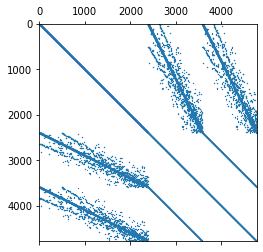

In [20]:
import scipy.sparse as sp
import matplotlib.pylab as plt
rows,cols,vals = A.mat.COO()
a = sp.csr_matrix((vals,(rows,cols)))
plt.spy(a, markersize=0.1)
# plt.savefig(f"../img/sparsity/sparsity-A.png", dpi=300)
plt.show()

In [21]:
P = Projector(ba_local_implicit_dofs, True)   # projection to small
P.shape

(4776, 4776)

In [22]:
aloc = P.T @ A.mat @ P

In [23]:
local = BaseMatrix(aloc)

In [24]:
amat = local.ToDense()

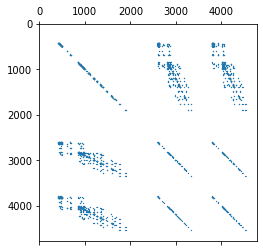

In [25]:
import scipy.sparse as sp
import matplotlib.pylab as plt

plt.spy(amat, markersize=0.1)
plt.show()

In [26]:
g = amat.NumPy()

In [27]:
A.mat.nze, np.count_nonzero(g)

(222912, 19202)

In [28]:
mstarlocbase = BaseMatrix(mstarloc)
mstarlocpattern = mstarlocbase.ToDense()

In [29]:
mstarbase = BaseMatrix(mstar)
mstarpattern = mstarbase.ToDense()

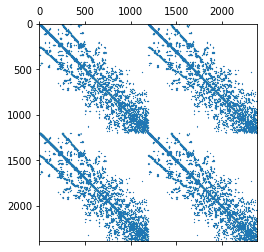

In [36]:
import scipy.sparse as sp
import matplotlib.pylab as plt
rows,cols,vals = A.mat.COO()
a = sp.csr_matrix((vals,(rows,cols)))
plt.spy(mstarpattern, markersize=0.1)
plt.show()

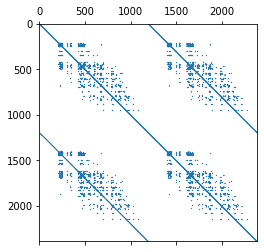

In [37]:
import scipy.sparse as sp
import matplotlib.pylab as plt
rows,cols,vals = A.mat.COO()
a = sp.csr_matrix((vals,(rows,cols)))
plt.spy(mstarlocpattern, markersize=0.1)
plt.show()

In [38]:
mstarnumpy, mstarlocnumpy = mstarpattern.NumPy(), mstarlocpattern.NumPy()

In [39]:
np.count_nonzero(mstarnumpy), np.count_nonzero(mstarlocnumpy)

(121398, 24701)